## Run community detection experiments for planted partition model

This script runs community detection on the eADAGE correlation network using the [planted partition model](https://en.wikipedia.org/wiki/Stochastic_block_model#Special_cases). Here, we use the implementation in the [graph-tool package](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#assortative-community-structure).

Using the planted partition model rather than the full stochastic block model ensures that communities are assortative (i.e. more connections within than across communities), which is what we're looking for in this analysis.

In [1]:
import os

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns

from sample_nodes import (
    sample_degree_matched,
    sort_by_degree,
)

gt.seed_rng(1)
np.random.seed(1)

In [2]:
# relevant file paths
data_dir = './data'
processed_graph = os.path.join(data_dir, 'eadage_generic_graph_unsigned.gt')

# script parameters
NUM_NODE_SAMPLES = 1000 # number of degree-matched node samples for permutation test
NUM_BINS = 100 # number of bins to divide nodes into, for sampling

In [3]:
G = gt.load_graph(processed_graph)
# make sure vertex/edge properties exist
print(G)
print(list(G.vp.keys()))
print(list(G.ep.keys()))

<Graph object, undirected, with 3477 vertices and 31556 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f7bf0632b80>
['name', 'generic']
['weight']


In [4]:
# community detection using planted partition model
state = gt.PPBlockState(G)
state.multiflip_mcmc_sweep(beta=np.inf, niter=1000)

(-62582.33286153246, 2911997, 166020)

In [5]:
print('k = {}'.format(state.get_B()))

k = 60


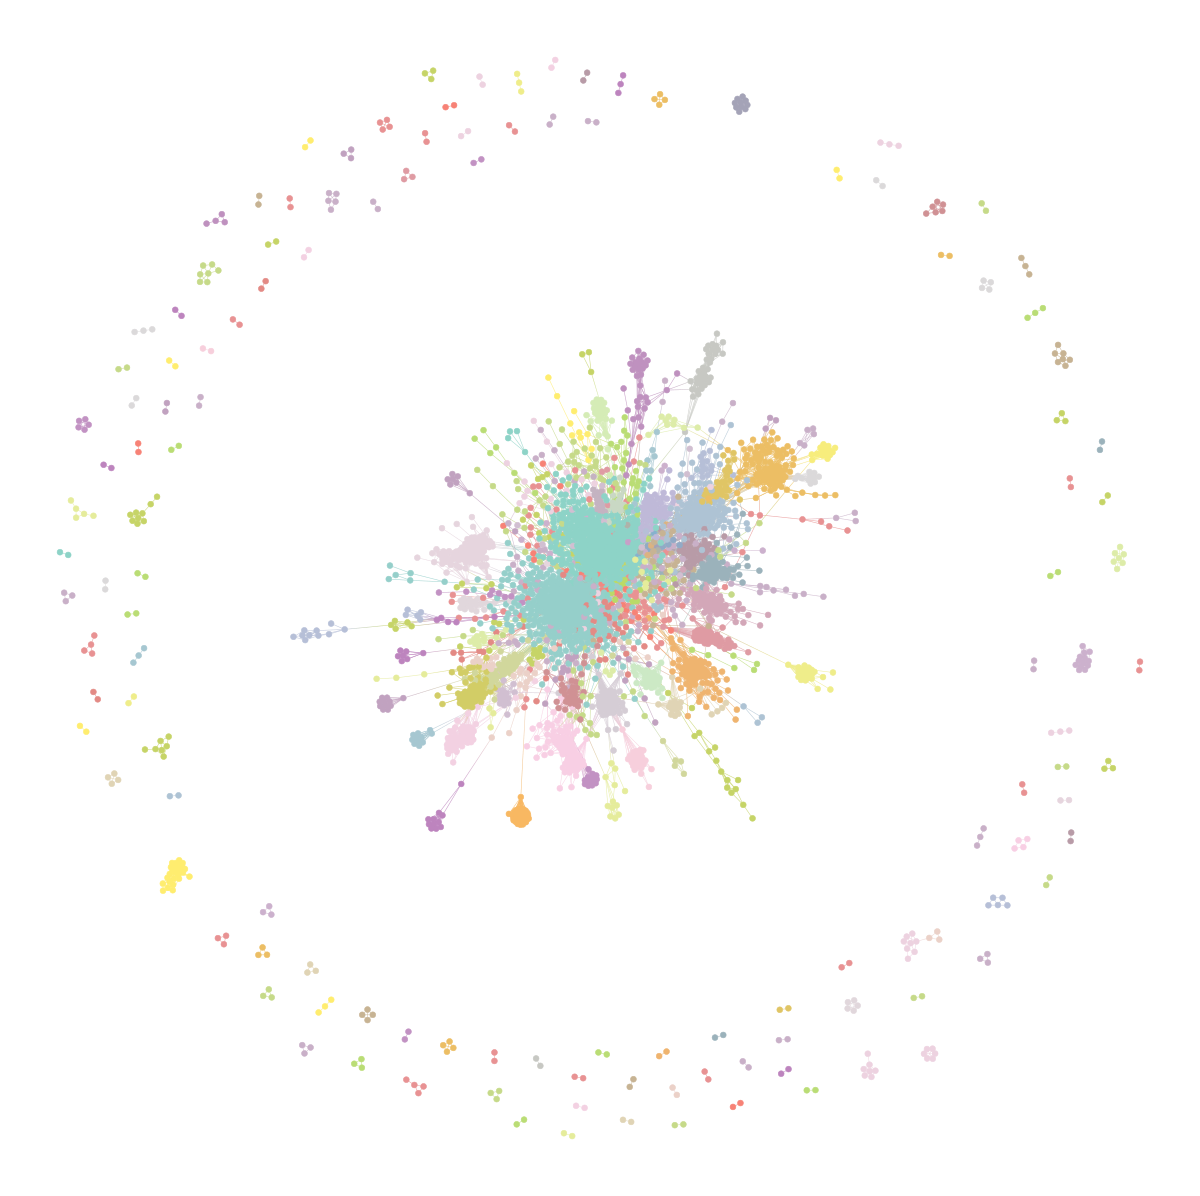

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7bf0632a90, at 0x7f7bf0632700>

In [6]:
state.draw()

In [7]:
# get dataframe mapping Pa genes to communities
def graph_state_to_df(G, state):
    labels = state.get_blocks().get_array()
    vs = G.get_vertices()
    names = [G.vp['name'][v] for v in vs]
    degrees = G.get_total_degrees(vs)
    is_generic = [G.vp['is_generic'][v] for v in vs]
    return pd.DataFrame({
        'gene': names,
        'label': labels,
        'degree': degrees,
        'is_generic': is_generic
    })

labels_df = graph_state_to_df(G, state)
print(len(labels_df.label.unique()))
labels_df.sort_values(by='degree', ascending=False).head()

60


,gene,label,degree,is_generic
26,PA4238,363,209,0
29,PA4245,363,201,0
30,PA4247,363,192,0
79,PA4252,363,181,0
27,PA4239,363,180,0


In [8]:
# simultaneously sort nodes and degrees by degree, ascending
nodes, degrees, is_generic = sort_by_degree(labels_df.gene.values,
                                            labels_df.degree.values,
                                            labels_df.is_generic.values)

# sample a few times and add results to df
for it in range(NUM_NODE_SAMPLES):
    s_nodes, s_degrees, __ = sample_degree_matched(nodes, degrees, is_generic,
                                                   num_bins=NUM_BINS)
    sampled = [1 if gene in s_nodes else 0 for gene in labels_df.gene]
    labels_df['sampled_{}'.format(it)] = sampled

labels_df.sort_values(by='degree', ascending=False).iloc[:5, :5]

,gene,label,degree,is_generic,sampled_0
26,PA4238,363,209,0,0
29,PA4245,363,201,0,0
30,PA4247,363,192,0,0
79,PA4252,363,181,0,0
27,PA4239,363,180,0,0


In [9]:
generic_count_df = (
    labels_df.groupby('label').sum()
             .drop(columns=['degree'])
)
print(generic_count_df.shape)
generic_count_df.sort_values(by='is_generic', ascending=False).iloc[:5, :5]

(60, 1001)


,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
label,,,,,
1264,55,12,8,7,5
1734,46,6,10,7,8
363,46,58,59,57,52
1946,25,5,7,3,3
2776,25,0,2,0,3


In [10]:
nonzero_counts_df = pd.DataFrame(
    [np.count_nonzero(generic_count_df, axis=0)],
    columns=generic_count_df.columns
)
nonzero_counts_df.iloc[:, :5]

,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
0,42,51,54,52,52


Text(0.5, 1.0, 'Number of communities, generic genes vs. 1000 degree-matched samples')

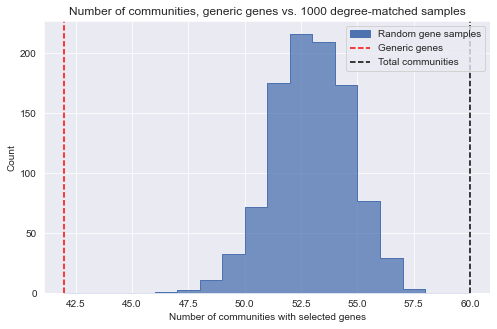

In [11]:
n_generic_groups = nonzero_counts_df.iloc[0, 0]
n_total_groups = len(labels_df.label.unique())

sns.set({'figure.figsize': (8, 5)})

sns.histplot(nonzero_counts_df.iloc[0, 1:].values,
             element='step',
             bins=np.arange(n_generic_groups, n_total_groups+1))
line1 = plt.gca().axvline(x=n_generic_groups,
                         linestyle='--', color='red')
line2 = plt.gca().axvline(x=n_total_groups,
                          linestyle='--', color='black')
plt.xlabel('Number of communities with selected genes')
plt.legend(handles=[mpatches.Patch(color=sns.color_palette()[0]), line1, line2],
           labels=['Random gene samples', 'Generic genes', 'Total communities'],
           loc='upper right')
plt.title('Number of communities, generic genes vs. {} degree-matched samples'.format(
    NUM_NODE_SAMPLES
))

This shows that the generic genes are spread across fewer communities than any of the degree-matched random gene samples, suggesting that generic genes may preferentially cluster in a few pathways or functional gene groups.

As a next step, we could calculate pathway/functional enrichment in the communities that tend to contain more generic genes than degree-matched random genes, and compare these to Alex's results with MultiPLIER.